In [1]:
using DifferentialEquations
using Plots
using Statistics
using QuadGK
using ImplicitPlots
using LinearAlgebra
using Roots

In [2]:
# 時間発展方程式を指定

#【使用する変数の一覧】
# S         生物種の種類の数
# N         利用可能な資源の種類の数
# a[i,j]    種iの資源jの利用率
# c[i]      種iが生存し続けるために必要なコスト
# u_ex      絶滅判定閾値

# R[j]      資源jの量
# K[j]      資源jの環境収容力
# ただし、Kは 平均ave, 振幅amp, 周波数f で振動させる
# r[j]      資源jの変化の速さ

# u[i]      種iの個体数
# Δ[i]     種iの過剰資源量
# T[j]      資源jの総要求量

In [3]:
function 方形波(A, f, t) # 周期1/fで±Aを振動する方形波 (矩形波)
    return A*sign(sin(2*π*f*t))
end

function のこぎり波(A, f, t) # 周期1/fで0からAの間を行き来するのこぎり波
    return A*(f*t - floor(f*t))
end

function 三角波(A, f, t) # 周期1/fで±Aの間を行き来する三角波
    return abs(のこぎり波(A,f,t-1/4/f)-A/2)*4 - A
end

# 周期1/fで±Aを行き来する台形波
# t = t1 で最大値Aに達する
function 台形波(A, f, t1, t)
    A1 = A/(4*f*t1)
    y = 三角波(A1,f,t)
    if abs(y) ≥ A
        return A*sign(y)
    else
        return y
    end
end

# 周期1/fで±Aを行き来する
# nが大きいほど方形波に近づいていく
function 滑らかな方形波(A, f, n, t)
    x = 2*f*t - floor(2*f*t)
    return A*(1 - abs(2*x-1)^n)*方形波(1,f,t)
end

滑らかな方形波 (generic function with 1 method)

In [4]:
function 周期的な変動(t, K_max, K_min, f, N)
    amp = (K_max - K_min)/2
    ave = (K_max + K_min)/2
    
    # 滑らかな方形波
    K = [ave[j] + 滑らかな方形波(abs(amp[j]),f,10,t)*(-1)^(j-1) for j in 1:N]
    
    return K
end

周期的な変動 (generic function with 1 method)

[ Info: Saved animation to C:\Users\ikumi\Downloads\提出用のコード, SI動画\K.gif


Plots.AnimatedGif("C:\\Users\\ikumi\\Downloads\\提出用のコード, SI動画\\K.gif")
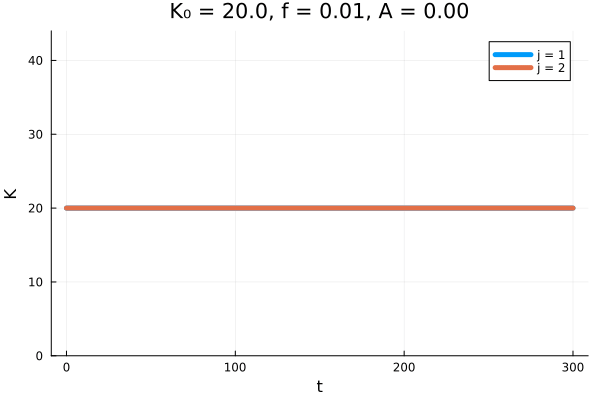

In [5]:
# 環境収容力K の時間変動を可視化
N = 2
K0 = ones(N)*20
f = 0.01
t_list = 0:(3/f/100):(3/f)
A=0.5
anim = Animation()
for A in 0:0.01:1
    K_max = K0*(1+A)
    K_min = K0*(1-A)

    plt = plot(xlabel="t", ylabel="K", yrange=[0, sum(K0)*1.1], 
        title = "K₀ = $(K0[1]), f = $f, A = "*rpad("$A", 4, "0"))
    for j in 1:N
        plot!(plt, t_list, [周期的な変動(t, K_max, K_min, f, N)[j] for t in t_list], 
            label="j = $j", lw=5)
    end
    frame(anim, plt)
end
#savefig(plt,"K.svg")
gif(anim, "K.gif", fps=5)

In [10]:
function 資源競争モデル(du, u, p, t)
    S,N,a,c,u_ex, K_max,K_min,f,r = p # パラメータの解凍 
    
    T = a'*u # T[j]は資源jの総要求量
    K = 周期的な変動(t, K_max, K_min, f, N) # K[j]は資源jの環境収容力
    R = K.*(1.0 .- T./r) # R[j]は資源jの量
    Δ = a*R - c # Δ[i]は種iの過剰資源
    
    for i in 1:S
        if u[i] < u_ex # 個体数がu_exを下回ったら絶滅
            du[i] = 0
            u[i] = 0
        else
            du[i] = Δ[i]*u[i]
        end
    end
end

資源競争モデル (generic function with 1 method)

In [11]:
# 初期条件を指定して微分方程式を解く 
function solve_ODE(p, u0, t_max) 
    tspan = (0.0, t_max) 
    prob = ODEProblem(資源競争モデル, u0, tspan, p) # 問題を定義 
    sol = solve(prob) # 微分方程式を解く 
    return sol 
end

solve_ODE (generic function with 1 method)

In [12]:
function uの時間平均(sol, from, to)
    return quadgk.(t->sol(t), from, to)[1] / (to - from)
end

uの時間平均 (generic function with 1 method)

In [20]:
S = 3 # 種の数
N = 2 # 資源の数

c = ones(S)*10 # 生存に要するコスト
u_ex = 10 # 絶滅の閾値

U = 50 # 個体数の目安

K0 = ones(N)*20 # 資源の環境収容力の平均値

L = 100 # メッシュの分割数
A_list = 0:(1/L):1 # 環境変動の大きさ
D_list = 0:(1/L):1 # 資源利用戦略の多様性
f = 0.001
r = ones(N)*(U) # 資源の内的増加率

u0 = ones(S)*U # t=0 における個体数
t_max = 1/f*10 # 計算時間

u_bar_list = []
for A in A_list, D in D_list
    K_max = K0*(1+A)
    K_min = K0*(1-A)
    
    a1 = [1/2+D/2, 1/2-D/2, 1/2]
    # 種1は資源1スペシャリスト
    # 種2は資源2スペシャリスト
    # 種3はジェネラリスト
    a = hcat(a1, ones(3)-a1)
    
    p = S,N,a,c,u_ex, K_max,K_min,f,r # パラメータをタプルにまとめる

    sol = solve_ODE(p, u0, t_max)
    u_bar = uの時間平均(sol, t_max*0.5, t_max)
    push!(u_bar_list, u_bar)
end
u_bar_list = reshape(u_bar_list, length(A_list), length(D_list))
u_bar_list = [[u_bar_list[iA, iD][i] for iA in 1:length(A_list), iD in 1:length(D_list)] for i in 1:S]

3-element Vector{Matrix{Float64}}:
 [16.666666666666792 16.66666666666679 … 16.666666655318238 16.66666711124214; 16.666666666673265 16.774068605654087 … 49.995473293097604 49.99480091416702; … ; 16.66666666665873 16.662288037904915 … 0.0 0.0; 16.66666666668778 16.657145019328244 … 0.0 0.0]
 [16.666666666666792 16.66666666666679 … 16.666666655318238 16.66666711124214; 16.666666666710853 16.688566512353646 … 0.0 0.0; … ; 16.66666666665873 16.662159689497045 … 0.0 0.0; 16.66666666668778 16.65721021135842 … 0.0 0.0]
 [16.666666666666792 16.66666666666679 … 16.666666655318238 16.666667111242116; 16.666666666616262 16.537326582337105 … 0.0 0.0; … ; 16.6666666666829 16.671203230905075 … 0.0 0.0; 16.6666666666248 16.681299331756506 … 0.0 0.0]

In [21]:
# 解析的に導出した相境界の描画
K1(A) = K0[1]*[1+A, 1-A]
K2(A) = K0[2]*[1-A, 1+A]
μ1(A) = r[1]*(1 .- c[1]./K1(A))
μ2(A) = r[2]*(1 .- c[2]./K2(A))

function avγ(A,D)
    a1 = [1/2+D/2, 1/2-D/2, 1/2]
    a = hcat(a1, ones(3)-a1)
    v = cross(a1, ones(S))
    γ = prod(u0.^v) # 保存量
    return a,v,γ
end

function F1(A,D) # 3種共存状態における種1の絶滅条件
    m1 = μ1(A)[2] # 種1は資源1が下がるときに絶滅する
    m2 = μ2(A)[2]
    a,v,γ = avγ(A,D)
    n1 = u_ex
    n2 = maximum([(a[3,2]*m1 - a[3,1]*m2 + v[2]*u_ex)/v[1], u_ex/2])
    n3 = maximum([(a[2,1]*m2 - a[2,2]*m1 + v[3]*u_ex)/v[1], u_ex/2])
    n = [n1, n2, n3]
    return prod(n.^v) - γ
end

function F2(A,D) # 3種共存状態における種2の絶滅条件
    m1 = μ1(A)[1] # 種2は資源2が下がるときに絶滅する
    m2 = μ2(A)[1]
    a,v,γ = avγ(A,D)
    n1 = maximum([(-a[3,2]*m1 + a[3,1]*m2 + v[1]*u_ex)/v[2], u_ex/2])
    n2 = u_ex
    n3 = maximum([(-a[1,1]*m2 + a[1,2]*m1 + v[3]*u_ex)/v[2], u_ex/2])
    n = [n1, n2, n3]
    return prod(n.^v) - γ
end

function G1(A,D) # 種2が既に絶滅している状況において、種1が絶滅する条件
    m1 = μ1(A)[2] # 種1は資源1が下がるときに絶滅する
    m2 = μ2(A)[2]
    a,v,γ = avγ(A,D)
    return a[3,2]*m1 - a[3,1]*m2 + v[2]*u_ex
end

function G2(A,D) # 種1が既に絶滅している状況において、種2が絶滅する条件
    m1 = μ1(A)[1] # 種2は資源2が下がるときに絶滅する
    m2 = μ2(A)[1]
    a,v,γ = avγ(A,D)
    return a[3,2]*m1 - a[3,1]*m2 - v[1]*u_ex
end

function G3(A,D) # 種2が既に絶滅している状況において、種3が絶滅する条件
    m1 = μ1(A)[1] # 種3は種1に資源を奪われることで絶滅する
    m2 = μ2(A)[1]
    a,v,γ = avγ(A,D)
    return a[1,2]*m1 - a[1,1]*m2 - v[2]*u_ex
end

function H1(A,D) # 種2,3が既に絶滅している状況において、種1が絶滅する条件
    k1 = K1(A)[2] # 種1は資源1が下がるときに絶滅する
    k2 = K2(A)[2]
    a,v,γ = avγ(A,D)
    R1 = k1*(1-a[1,1]*u_ex/r[1])
    R2 = k2*(1-a[1,2]*u_ex/r[2])
    return a[1,1]*R1 + a[1,2]*R2 - c[1]
end

function H2(A,D) # 種1,3が既に絶滅している状況において、種2が絶滅する条件
    k1 = K1(A)[1] # 種2は資源2が下がるときに絶滅する
    k2 = K2(A)[1]
    a,v,γ = avγ(A,D)
    R1 = k1*(1-a[2,1]*u_ex/r[1])
    R2 = k2*(1-a[2,2]*u_ex/r[2])
    return a[2,1]*R1 + a[2,2]*R2 - c[2]
end

H2 (generic function with 1 method)

In [22]:
function 理論線を重ね描き(plt)
    plt = contour!(plt, A_list, D_list, F2, levels=[10^-3], c="skyblue", w=3, s=:solid)
    contour!(plt, A_list, D_list, G3, levels=[10^-3], c="skyblue", w=3, s=:dash)
    contour!(plt, A_list, D_list, H1, levels=[10^-3], c="skyblue", w=3, s=:dot)
    return plt
end

理論線を重ね描き (generic function with 1 method)

┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528
┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528
┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528
┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528
┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528


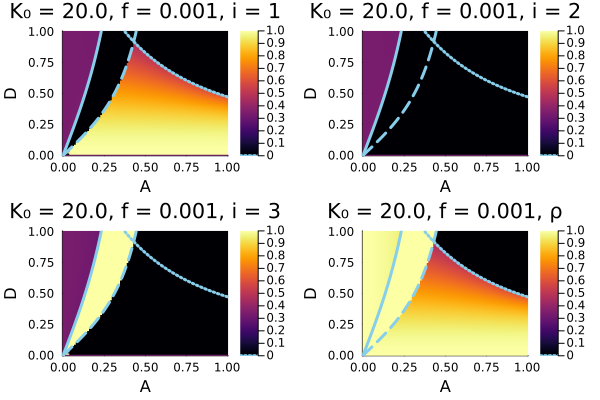

┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528
┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528
┌ Warning: Multiple series with different line style share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\ikumi\.julia\packages\Plots\sxUvK\src\backends\gr.jl:528


In [23]:
plts = []
for i in 1:S
    plt = plot(xlabel="A", ylabel="D", title="K₀ = $(K0[1]), f = $f, i = $i")
    heatmap!(plt, A_list, D_list, u_bar_list[i]./(U), clims=(0,1))
    plt = 理論線を重ね描き(plt)
    push!(plts, plt)
end

ρ = sum(u_bar_list)./(U)
plt = plot(xlabel="A", ylabel="D", title="K₀ = $(K0[1]), f = $f, ρ")
heatmap!(plt, A_list, D_list, ρ, clims=(0,1))
plt = 理論線を重ね描き(plt)
push!(plts, plt)

plt4 = plot(plts...)
savefig(plt4, "K0$(K0[1])_f$(f).svg")
plot(plt4)

In [24]:
F1_D1(A) = F1(A,1)
find_zero(F1_D1, (0,1)) # ()の範囲内で F1(A,1)=0 の解を探索

0.23177112573551056

In [25]:
G3_D1(A) = G3(A,1)
find_zero(G3_D1, (0,1)) # ()の範囲内で G3(A,1)=0 の解を探索

0.44444444444444436

In [26]:
H1_D1(A) = H1(A,1)
find_zero(H1_D1, (0,1)) # ()の範囲内で H1(A,1)=0 の解を探索

0.3750000000000001